In [26]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import PIL
from PIL import Image
import os
import csv
import matplotlib.pyplot as plt
import random
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras import models
from keras import layers
from keras.models import load_model
from tensorflow.keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator

In [27]:
df = pd.read_csv('C:\\Users\\Ivona\\Desktop\\MacedonianSignLanguage\\input\\data.csv')
X = df.image_path.values
y = df.target.values
(train_x, test_x, train_y, test_y) = (train_test_split(X, y, 
                                test_size=0.25, random_state=42))
print(f"Training on {len(train_x)} images")
print(f"Validationg on {len(test_x)} images")

Training on 9135 images
Validationg on 3045 images


In [28]:
tr_x = pd.DataFrame(train_x)

In [29]:
tr_y = pd.DataFrame(train_y)

In [30]:
images_train = []

for i in range(0,9135):
    file_path=tr_x.iloc[i][0]
    image = Image.open(file_path)
    image_data = np.array(image)
    images_train.append(image_data)

images_train = np.array(images_train)

In [31]:
te_x = pd.DataFrame(test_x)

In [32]:
te_y = pd.DataFrame(test_y)

In [33]:
images_test = []

for i in range(0,3045):
    file_path=te_x.iloc[i][0]
    image = Image.open(file_path)
    image_data = np.array(image)
    images_test.append(image_data)

images_test= np.array(images_test)

In [34]:
train_y_new = np_utils.to_categorical(train_y)
test_y_new= np_utils.to_categorical(test_y)

In [35]:
test = pd.read_csv("test.csv")

In [36]:
test_labels = test['target']

In [37]:
test_labels_new = np_utils.to_categorical(test_labels)

In [38]:
test_paths = test['image_path']

In [39]:
test_images = []

for i in range(0,58):
    file_path=test_paths.iloc[i]
    image = Image.open(file_path).resize((224,224))
    image_data = np.array(image)
    test_images.append(image_data)

test_images= np.array(test_images)

In [40]:
num_classes = test_y_new.shape[1]

In [41]:
labels = {
 0:"A",1:"Agol",2:"Amin",3:"B",4:"Beskonechnost",5:"C",6:"CH",7:"Centar",8:"Cvekje",9:"D",10:"DJ",
11:"DZ",12:"Delenje",13:"Dopir",14:"E",15:"F",16:"Fizika",17:"G",18:"H",19:"I",20:"Jas",21:"Javanje",22:"K",
23:"Kolache",24:"Korona",25:"Krst",26:"Kukja",27:"L",28:"LJ",29:"M",30:"Mnogu",31:"N",32:"NJ",33:"O",34:"P",
35:"Peperutka",36:"Pritisok",37:"Prst",38:"R",39:"Rob",40:"S",41:"SH",42:"Sever",43:"Sida",44:"Sin",45:"Svekja",
46:"T",47:"Telefon",48:"TojTaaToa",49:"U",50:"V",51:"Valkano",52:"Vilushka",53:"Z",54:"ZH",55:"Zamenki",56:"Zholtica",57:"Zoshto"
}

In [42]:
train_df = pd.concat([tr_x, tr_y], axis=1)
train_df.columns = ['path', 'target']

In [43]:
test_df = pd.concat([te_x, te_y], axis=1)
test_df.columns = ['path', 'target']

In [44]:
train_df['target'] = train_df['target'].apply(str)
test_df['target'] = test_df['target'].apply(str)

In [45]:
test['target'] = test['target'].apply(str)

In [21]:
base_model = ResNet50(input_shape=(224, 224,3), include_top=False, weights="imagenet")

94765736/94765736 [==============================] - 13s 0us/step


In [23]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [25]:
model1 = Sequential()
model1.add(base_model)
model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(num_classes, activation='softmax'))

In [26]:
print('trainable weights before freezing the base model:', len(model1.trainable_weights))

trainable weights before freezing the base model: 222


In [27]:
base_model.trainable=False

In [28]:
print('trainable weights after freezing the base model:', len(model1.trainable_weights))

trainable weights after freezing the base model: 10


In [46]:
train_datagen = ImageDataGenerator(
    rotation_range=10, 
    width_shift_range=0.03,
    height_shift_range=0.03,
    shear_range=0.03,
    zoom_range=0.03,
    horizontal_flip=True,
)
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='target',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)
validation_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='target',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 9135 validated image filenames belonging to 58 classes.
Found 3045 validated image filenames belonging to 58 classes.


In [30]:
model1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [33]:
history1 = model1.fit_generator(
      train_generator,
      steps_per_epoch=143,
      epochs=5,
      validation_data=validation_generator,
      validation_steps=48,verbose=2)

C:\Users\Ivona\AppData\Local\Temp/ipykernel_10504/644586536.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1 = model1.fit_generator(


Epoch 1/5
143/143 - 433s - loss: 1.9824 - acc: 0.4786 - val_loss: 0.3020 - val_acc: 0.9218 - 433s/epoch - 3s/step
Epoch 2/5
143/143 - 437s - loss: 0.2084 - acc: 0.9422 - val_loss: 0.0975 - val_acc: 0.9724 - 437s/epoch - 3s/step
Epoch 3/5
143/143 - 439s - loss: 0.0849 - acc: 0.9760 - val_loss: 0.0972 - val_acc: 0.9714 - 439s/epoch - 3s/step
Epoch 4/5
143/143 - 452s - loss: 0.1185 - acc: 0.9675 - val_loss: 0.0558 - val_acc: 0.9826 - 452s/epoch - 3s/step
Epoch 5/5
143/143 - 435s - loss: 0.0491 - acc: 0.9860 - val_loss: 0.0210 - val_acc: 0.9944 - 435s/epoch - 3s/step


In [34]:
model1.save('ResNet_model.h5')

In [47]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='image_path',
    y_col='target',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical')

Found 58 validated image filenames belonging to 58 classes.


In [48]:
model1_1 = load_model('ResNet_model.h5')

In [49]:
loss1,test_accuracy1 = model1_1.evaluate_generator(test_generator)
print("Test accuracy:",test_accuracy1)

C:\Users\Ivona\AppData\Local\Temp/ipykernel_6384/3732549942.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss1,test_accuracy1 = model1_1.evaluate_generator(test_generator)


Test accuracy: 0.9655172228813171


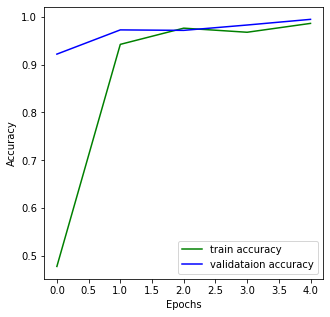

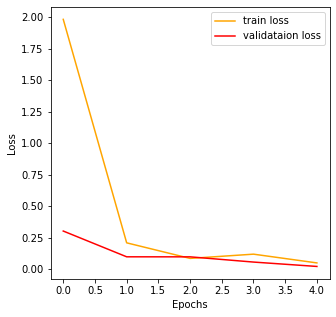

In [174]:
plt.figure(figsize=(5,5))
plt.plot(history1.history['acc'], color='green', label='train accuracy')
plt.plot(history1.history['val_acc'], color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(5, 5))
plt.plot(history1.history['loss'], color='orange', label='train loss')
plt.plot(history1.history['val_loss'], color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [63]:
model1_2 = load_model('ResNet_model.h5')

In [64]:
model1_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_5 (Dense)             (None, 256)               25690368  
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 58)               

In [65]:
base_model2 = model1_2.get_layer(name='resnet50')

In [66]:
for i, layer in enumerate(base_model2.layers):
    if i < len(base_model2.layers) - 5:
        layer.trainable = False
    else:
        layer.trainable = True

In [175]:
model1_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_5 (Dense)             (None, 256)               25690368  
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 58)               

In [67]:
model1_2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [68]:
history2_2 = model1_2.fit_generator(
      train_generator,
      steps_per_epoch=143,
      epochs=5,
      validation_data=validation_generator,
      validation_steps=48,verbose=2)

C:\Users\Ivona\AppData\Local\Temp/ipykernel_10504/2761524905.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2_2 = model1_2.fit_generator(


Epoch 1/5
143/143 - 450s - loss: 0.1824 - acc: 0.9508 - val_loss: 0.2162 - val_acc: 0.9491 - 450s/epoch - 3s/step
Epoch 2/5
143/143 - 444s - loss: 0.0484 - acc: 0.9871 - val_loss: 0.0603 - val_acc: 0.9773 - 444s/epoch - 3s/step
Epoch 3/5
143/143 - 434s - loss: 0.0518 - acc: 0.9849 - val_loss: 0.0738 - val_acc: 0.9826 - 434s/epoch - 3s/step
Epoch 4/5
143/143 - 405s - loss: 0.0417 - acc: 0.9889 - val_loss: 0.0404 - val_acc: 0.9898 - 405s/epoch - 3s/step
Epoch 5/5
143/143 - 406s - loss: 0.0447 - acc: 0.9866 - val_loss: 0.0314 - val_acc: 0.9915 - 406s/epoch - 3s/step


In [69]:
model1_2.save('ResNet_model2.h5')

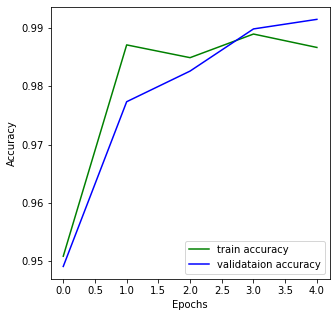

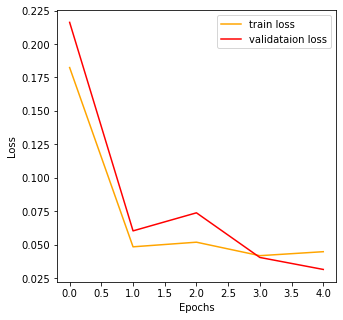

In [171]:
plt.figure(figsize=(5, 5))
plt.plot(history2_2.history['acc'], color='green', label='train accuracy')
plt.plot(history2_2.history['val_acc'], color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(5, 5))
plt.plot(history2_2.history['loss'], color='orange', label='train loss')
plt.plot(history2_2.history['val_loss'], color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [50]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='image_path',
    y_col='target',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',shuffle=False)

Found 58 validated image filenames belonging to 58 classes.


In [51]:
model1_2 = load_model('ResNet_model2.h5')

In [52]:
loss2,test_accuracy2 = model1_2.evaluate_generator(test_generator)
print("Test accuracy:",test_accuracy2)

C:\Users\Ivona\AppData\Local\Temp/ipykernel_6384/4112285154.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss2,test_accuracy2 = model1_2.evaluate_generator(test_generator)


Test accuracy: 1.0


In [53]:
files=test_generator.filenames
class_dict=test_generator.class_indices 
rev_dict={}
for key, value in class_dict.items():
    rev_dict[value]=key 

In [54]:
predictions5 = model1_2.predict(test_generator)

1/1 [==============================] - 4s 4s/step


In [55]:
for i, p in enumerate(predictions5):
    index=np.argmax(p)
    class_=rev_dict[index]    
    prob=p[index]
    print('For',files[i], ' predicted class is ', class_,' with probability ',prob)

For C:\Users\Ivona\Desktop\MacedonianSignLanguage\input\test\1.jpg  predicted class is  28.0  with probability  0.96224713
For C:\Users\Ivona\Desktop\MacedonianSignLanguage\input\test\2.jpg  predicted class is  54.0  with probability  0.99999994
For C:\Users\Ivona\Desktop\MacedonianSignLanguage\input\test\3.jpg  predicted class is  57.0  with probability  0.99999887
For C:\Users\Ivona\Desktop\MacedonianSignLanguage\input\test\4.jpg  predicted class is  47.0  with probability  0.9999922
For C:\Users\Ivona\Desktop\MacedonianSignLanguage\input\test\5.jpg  predicted class is  21.0  with probability  0.99999255
For C:\Users\Ivona\Desktop\MacedonianSignLanguage\input\test\6.jpg  predicted class is  25.0  with probability  0.9999569
For C:\Users\Ivona\Desktop\MacedonianSignLanguage\input\test\7.jpg  predicted class is  1.0  with probability  0.9999998
For C:\Users\Ivona\Desktop\MacedonianSignLanguage\input\test\8.jpg  predicted class is  16.0  with probability  0.99999994
For C:\Users\Ivona\D

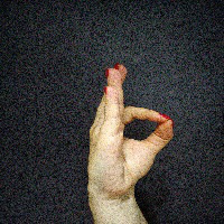

In [143]:
image3_3 = Image.open(test_generator.filenames[31]).resize((224,224))
image3_3

In [144]:
image3 = np.array(image3_3)

In [145]:
image3 = image3.reshape(1,224,224,3)

In [149]:
predictions6 = model1_2.predict(image3)

1/1 [==============================] - 0s 86ms/step


In [170]:
for i, p in enumerate(predictions6):
    index=np.argmax(p)
    class_=rev_dict[index]
    num = int(float(class_))
    print('Predicted class is',labels[num],'with index',class_)

Predicted class is F with index 15.0


Najdobar model e ResNet_model2.h5